# Import libraries

In [1]:
import numpy as np
import MRzeroCore as mr0
import pypulseq as pp
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rcParams['figure.dpi'] = 100

# Load a phantom

In [ ]:
mr0.generate_brainweb_phantoms("phantom", "3T") # Just load the first phantom is enough

Generating '3T', subject 4
Adding tissue to phantom - done
Adding tissue to phantom - done
Adding tissue to phantom - done
Saving to 'subject04_3T.npz' - done

Generating '3T', subject 5
Adding tissue to phantom - done
Adding tissue to phantom - done
Adding tissue to phantom - done
Saving to 'subject05_3T.npz' - done

Generating '3T', subject 6
Adding tissue to phantom - done
Adding tissue to phantom - done

VoxelGridPhantom
size = tensor([0.1810, 0.2170, 0.1810])


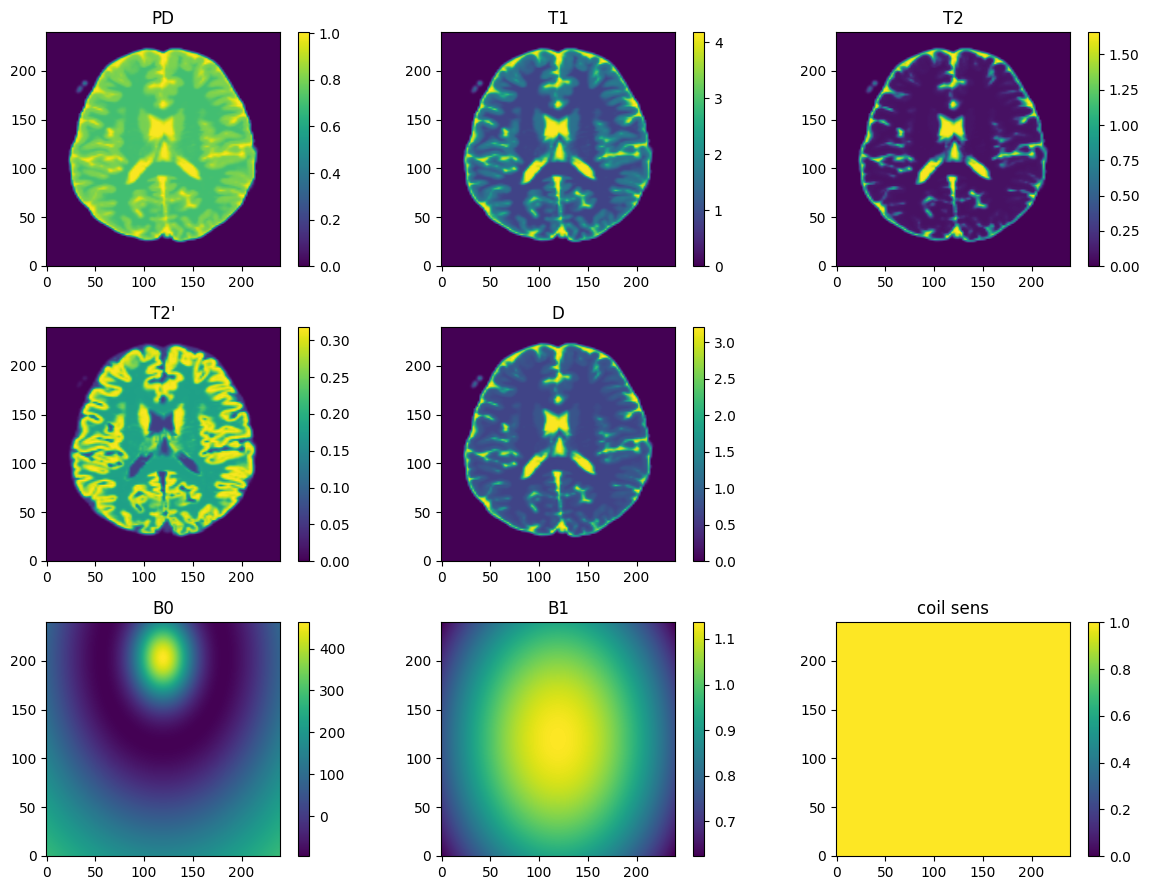

In [3]:
phantom_size = 240
# phantom = mr0.VoxelGridPhantom.load_mat(rf'phantom\numerical_brain_cropped.mat')
# phantom = mr0.util.load_phantom(size=(128,128))
phantom = mr0.VoxelGridPhantom.load("phantom/subject04_3T.npz")
phantom = phantom.interpolate(phantom_size, phantom_size, 1)
data = phantom.build()
phantom.B0*=10
phantom.plot()

# Load a Pulseq file, then do simulation and reconstruction

>>>> Rust - compute_graph(...) >>>
Converting Python -> Rust: 0.001829368 s
Compute Graph
Computing Graph: 1.8828993 s
Analyze Graph
Analyzing Graph: 0.025234211 s


Converting Rust -> Python: 1.0798067 s
<<<< Rust <<<<


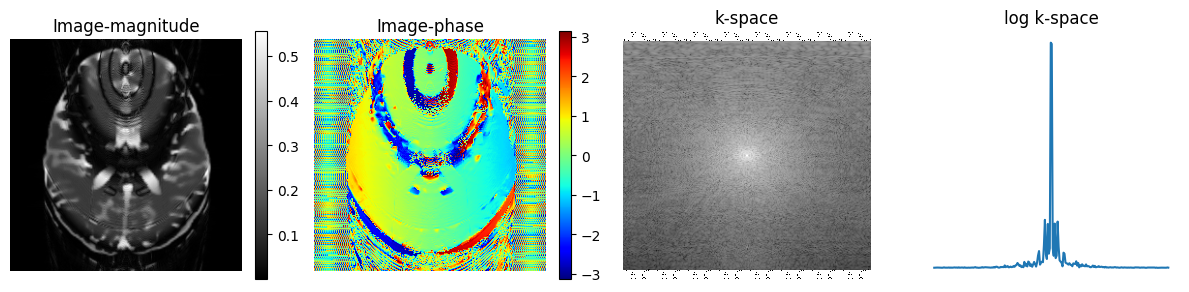

In [4]:
seq_path = "seq/bSSFP.seq"
# seq_path = "seq/ubSSFP_1.33.seq"

seq = pp.Sequence()
seq.read(seq_path)
signal, _ = mr0.util.simulate(seq, phantom)

# k_space_size = np.sqrt(signal.size()[0]).astype(int)
# DESS
# k_space_size = np.sqrt(signal.size()[0]/2).astype(int)
# print(rf"K space size: {k_space_size}")
# print(signal.size())
# k_space = signal.reshape(k_space_size, k_space_size)
k_space = signal.reshape(phantom_size, -1)
spectrum = torch.fft.ifftshift(k_space)
space = torch.fft.ifft2(spectrum)
space = torch.fft.fftshift(space)

# Plot the result
fraction = 0.05

fig, axes = plt.subplots(1, 4, figsize=(12, 3))

axes[0].set_title('Image-magnitude')
ax0 = axes[0].imshow(np.abs(space.numpy()), cmap="gray")
fig.colorbar(ax0, ax=axes[0], fraction=fraction)

axes[1].set_title('Image-phase')
ax1 = axes[1].imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi, cmap="jet")
fig.colorbar(ax1, ax=axes[1], fraction=fraction)

axes[2].set_title('k-space')
ax2 = axes[2].imshow(np.abs(k_space.numpy()), cmap="gray", norm=LogNorm())

axes[3].set_title('log k-space')
# ax3 = axes[3].imshow(np.log(np.abs(k_space.numpy())), cmap=cmap)
# ax3 = axes[3].imshow(np.abs(k_space.numpy()), cmap="grya", norm=LogNorm())
ax3 = axes[3].plot(np.abs(k_space.numpy())[k_space.shape[0]//2,:])

for ax in axes:
    ax.axis("off")

fig.tight_layout()

>>>> Rust - compute_graph(...) >>>
Converting Python -> Rust: 0.002367142 s
Compute Graph
Computing Graph: 1.4239411 s
Analyze Graph
Analyzing Graph: 0.013982226 s


Converting Rust -> Python: 0.49296254 s
<<<< Rust <<<<


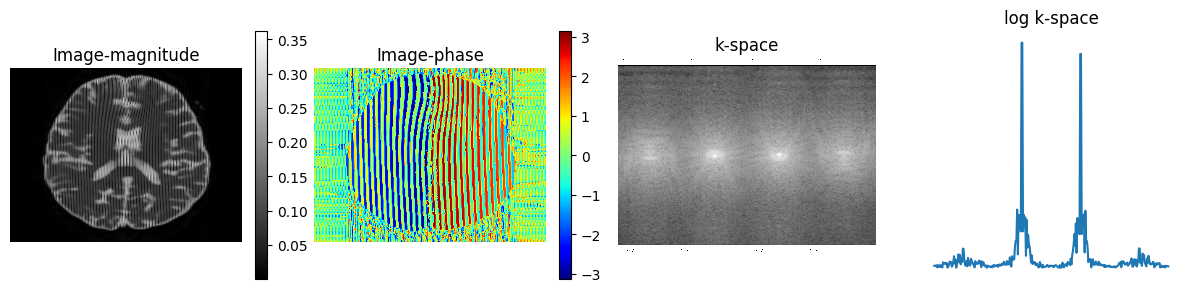

In [5]:
# seq_path = "seq/bSSFP.seq"
seq_path = "seq/ubSSFP_1.33.seq"

seq = pp.Sequence()
seq.read(seq_path)
signal, _ = mr0.util.simulate(seq, phantom)

# k_space_size = np.sqrt(signal.size()[0]).astype(int)
# DESS
# k_space_size = np.sqrt(signal.size()[0]/2).astype(int)
# print(rf"K space size: {k_space_size}")
# print(signal.size())
# k_space = signal.reshape(k_space_size, k_space_size)
k_space = signal.reshape(phantom_size, -1)
spectrum = torch.fft.ifftshift(k_space)
space = torch.fft.ifft2(spectrum)
space = torch.fft.fftshift(space)

# Plot the result
fraction = 0.05

fig, axes = plt.subplots(1, 4, figsize=(12, 3))

axes[0].set_title('Image-magnitude')
ax0 = axes[0].imshow(np.abs(space.numpy()), cmap="gray")
fig.colorbar(ax0, ax=axes[0], fraction=fraction)

axes[1].set_title('Image-phase')
ax1 = axes[1].imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi, cmap="jet")
fig.colorbar(ax1, ax=axes[1], fraction=fraction)

axes[2].set_title('k-space')
ax2 = axes[2].imshow(np.abs(k_space.numpy()), cmap="gray", norm=LogNorm())

axes[3].set_title('log k-space')
# ax3 = axes[3].imshow(np.log(np.abs(k_space.numpy())), cmap=cmap)
# ax3 = axes[3].imshow(np.abs(k_space.numpy()), cmap="grya", norm=LogNorm())
ax3 = axes[3].plot(np.abs(k_space.numpy())[k_space.shape[0]//2,:])

for ax in axes:
    ax.axis("off")

fig.tight_layout()

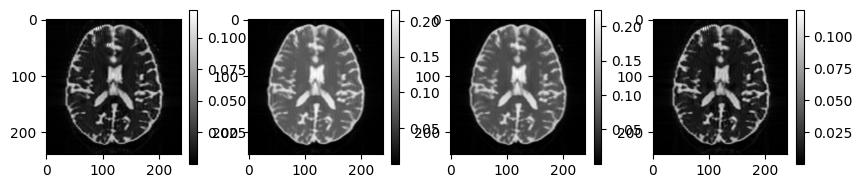

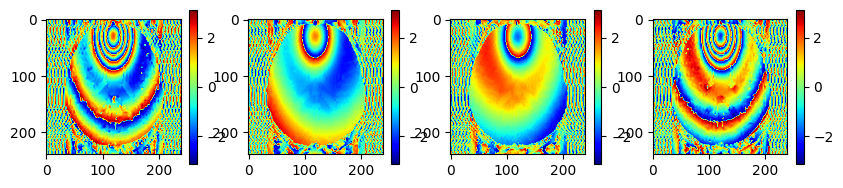

In [6]:
import torch.nn.functional as F
k_space.shape
k_echo_1 = k_space[:,:k_space.shape[1]//4]
k_echo_0 = k_space[:,k_space.shape[1]//4:k_space.shape[1]//2]
k_echo_n1 = k_space[:,k_space.shape[1]//2:3*k_space.shape[1]//4]
k_echo_n2 = k_space[:,3*k_space.shape[1]//4:]

k_echo_1 = F.pad(k_echo_1, (k_space.shape[1]//4, k_space.shape[1]//4), mode='constant', value=0)
k_echo_0 = F.pad(k_echo_0, (k_space.shape[1]//4, k_space.shape[1]//4), mode='constant', value=0)
k_echo_n1 = F.pad(k_echo_n1, (k_space.shape[1]//4, k_space.shape[1]//4), mode='constant', value=0)
k_echo_n2 = F.pad(k_echo_n2, (k_space.shape[1]//4, k_space.shape[1]//4), mode='constant', value=0)

m_1 = torch.fft.ifftshift(torch.fft.ifft2(torch.fft.ifftshift(k_echo_1)))
m_0 = torch.fft.ifftshift(torch.fft.ifft2(torch.fft.ifftshift(k_echo_0)))
m_n1 = torch.fft.ifftshift(torch.fft.ifft2(torch.fft.ifftshift(k_echo_n1)))
m_n2 = torch.fft.ifftshift(torch.fft.ifft2(torch.fft.ifftshift(k_echo_n2)))

plt.figure(figsize=(10, 2))
plt.subplot(141)
plt.imshow(np.abs(m_1.numpy()), cmap="gray")
plt.colorbar()
plt.subplot(142)
plt.imshow(np.abs(m_0.numpy()), cmap="gray")
plt.colorbar()
plt.subplot(143)
plt.imshow(np.abs(m_n1.numpy()), cmap="gray")
plt.colorbar()
plt.subplot(144)
plt.imshow(np.abs(m_n2.numpy()), cmap="gray")
plt.colorbar()
plt.show()

plt.figure(figsize=(10, 2))
plt.subplot(141)
plt.imshow(np.angle(m_1.numpy()), cmap="jet")
plt.colorbar()
plt.subplot(142)
plt.imshow(np.angle(m_0.numpy()), cmap="jet")
plt.colorbar()
plt.subplot(143)
plt.imshow(np.angle(m_n1.numpy()), cmap="jet")
plt.colorbar()
plt.subplot(144)
plt.imshow(np.angle(m_n2.numpy()), cmap="jet")
plt.colorbar()
plt.show()


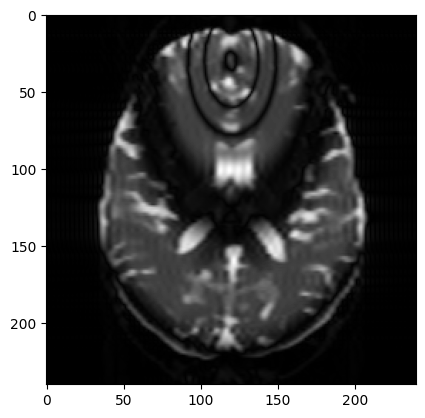

In [7]:
plt.imshow(np.abs((m_1+m_0+m_n1+m_n2).numpy()), cmap="gray")

In [8]:
# seq_name = rf"solext3_gre_demo_2d_fov_shift_XXX"  # your sequence exp id in the matlab script
# seq_name = rf"solext2_gre_demo_2d_IR_XXX"  # your sequence exp id in the matlab script
# seq_name = rf"ex17_gre_demo_2d_Label_XXX"  # your sequence exp id in the matlab script
seq_name = rf"bssfp"
# seq_name = rf"DESS"
seq_path = rf"seq\{seq_name}.seq"

seq = pp.Sequence()
seq.read(seq_path)
signal, _ = mr0.util.simulate(seq, phantom)

k_space_size = np.sqrt(signal.size()[0]).astype(int)
# DESS
# k_space_size = np.sqrt(signal.size()[0]/2).astype(int)
print(rf"K space size: {k_space_size}")
# print(signal.size())
k_space = signal.reshape(k_space_size, k_space_size)
spectrum = torch.fft.ifftshift(k_space)
space = torch.fft.ifft2(spectrum)
space = torch.fft.fftshift(space)
# # DESS
# k_space = signal.reshape(k_space_size, k_space_size, 2)
# spectrum = torch.fft.ifftshift(k_space, axes=(0,1))
# space = torch.fft.ifft2(spectrum, axes=(0,1))
# space = torch.fft.fftshift(space, axes=(0,1))

# Plot the result
fraction = 0.05
cmap = None
# cmap = "gray"

fig, axes = plt.subplots(1, 4, figsize=(8, 6))

axes[0].set_title('Image-magnitude')
ax0 = axes[0].imshow(np.abs(space.numpy()), cmap="gray")
# ax0 = axes[0].imshow(np.roll(np.abs(space.numpy()), space.shape[0]//2, axis=0), cmap=cmap)
fig.colorbar(ax0, ax=axes[0], fraction=fraction)

axes[1].set_title('Image-phase')
ax1 = axes[1].imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi, cmap=cmap)
# ax1 = axes[1].imshow(np.roll(np.angle(space.numpy()), space.shape[0]//2, axis=0), vmin=-np.pi, vmax=np.pi, cmap=cmap)
fig.colorbar(ax1, ax=axes[1], fraction=fraction)

axes[2].set_title('k-space')
ax2 = axes[2].imshow(np.abs(k_space.numpy()), cmap=cmap)

axes[3].set_title('log k-space')
# ax3 = axes[3].imshow(np.log(np.abs(k_space.numpy())), cmap=cmap)
ax3 = axes[3].imshow(np.abs(k_space.numpy()), cmap=cmap, norm=LogNorm())

for ax in axes:
    ax.axis("off")

fig.tight_layout()

FileNotFoundError: [Errno 2] No such file or directory: 'seq\\bssfp.seq'

In [ ]:
from einops import rearrange
# seq_name = rf"solext3_gre_demo_2d_fov_shift_XXX"  # your sequence exp id in the matlab script
# seq_name = rf"solext2_gre_demo_2d_IR_XXX"  # your sequence exp id in the matlab script
# seq_name = rf"ex17_gre_demo_2d_Label_XXX"  # your sequence exp id in the matlab script
# seq_name = rf"bssfp"
seq_name = rf"DESS"
seq_path = rf"..\seq\{seq_name}.seq"

seq = pp.Sequence()
seq.read(seq_path)
signal, _ = mr0.util.simulate(seq, phantom)

k_space_size = np.sqrt(signal.size()[0]).astype(int)
# DESS
k_space_size = np.sqrt(signal.size()[0]/2).astype(int)
print(rf"K space size: {k_space_size}")
# print(signal.size())
# k_space = signal.reshape(k_space_size, k_space_size)
# spectrum = torch.fft.ifftshift(k_space)
# space = torch.fft.ifft2(spectrum)
# space = torch.fft.fftshift(space)
# DESS
k_space = signal.reshape(k_space_size, 2, k_space_size)
k_space = rearrange(k_space, 'h c w -> h w c')
spectrum = torch.fft.ifftshift(k_space, dim=(0,1))
space = torch.fft.ifft2(spectrum, dim=(0,1))
space = torch.fft.fftshift(space, dim=(0,1))

# Plot the result
fraction = 0.05
# cmap = None
cmap = "gray"

fig, axes = plt.subplots(1, 4, figsize=(8, 6))

axes[0].set_title('Image-magnitude')
ax0 = axes[0].imshow(np.abs(space.numpy())[:,:,0], cmap=cmap)
# ax0 = axes[0].imshow(np.roll(np.abs(space.numpy()), space.shape[0]//2, axis=0), cmap=cmap)
fig.colorbar(ax0, ax=axes[0], fraction=fraction)

axes[1].set_title('Image-phase')
ax1 = axes[1].imshow(np.angle(space.numpy())[:,:,0], vmin=-np.pi, vmax=np.pi, cmap="jet")
# ax1 = axes[1].imshow(np.roll(np.angle(space.numpy()), space.shape[0]//2, axis=0), vmin=-np.pi, vmax=np.pi, cmap=cmap)
fig.colorbar(ax1, ax=axes[1], fraction=fraction)

axes[2].set_title('k-space')
ax2 = axes[2].imshow(np.abs(k_space.numpy())[:,:,0], cmap=cmap)

axes[3].set_title('log k-space')
# ax3 = axes[3].imshow(np.log(np.abs(k_space.numpy())), cmap=cmap)
ax3 = axes[3].imshow(np.abs(k_space.numpy())[:,:,0], cmap=cmap, norm=LogNorm())

for ax in axes:
    ax.axis("off")

fig.tight_layout()

fig, axes = plt.subplots(1, 4, figsize=(8, 6))

axes[0].set_title('Image-magnitude')
ax0 = axes[0].imshow(np.abs(space.numpy())[:,:,1], cmap=cmap)
# ax0 = axes[0].imshow(np.roll(np.abs(space.numpy()), space.shape[0]//2, axis=0), cmap=cmap)
fig.colorbar(ax0, ax=axes[0], fraction=fraction)

axes[1].set_title('Image-phase')
ax1 = axes[1].imshow(np.angle(space.numpy())[:,:,1], vmin=-np.pi, vmax=np.pi, cmap="jet")
# ax1 = axes[1].imshow(np.roll(np.angle(space.numpy()), space.shape[0]//2, axis=0), vmin=-np.pi, vmax=np.pi, cmap=cmap)
fig.colorbar(ax1, ax=axes[1], fraction=fraction)

axes[2].set_title('k-space')
ax2 = axes[2].imshow(np.abs(k_space.numpy())[:,:,1], cmap=cmap)

axes[3].set_title('log k-space')
# ax3 = axes[3].imshow(np.log(np.abs(k_space.numpy())), cmap=cmap)
ax3 = axes[3].imshow(np.abs(k_space.numpy())[:,:,1], cmap=cmap, norm=LogNorm())

for ax in axes:
    ax.axis("off")

fig.tight_layout()
plt.show()

# plt.imshow(np.abs(space.numpy().sum(axis=-1)))
from skimage.restoration import unwrap_phase
plt.subplot(221)
plt.imshow(np.angle(space[:,:,0]*space[:,:,1].conj()), cmap='jet')
plt.colorbar()
plt.subplot(222)
plt.imshow(unwrap_phase(np.angle(space[:,:,0]*space[:,:,1].conj())), cmap='jet')
plt.colorbar()
plt.subplot(223)
# plt.imshow(np.abs(space[:,:,0]+space[:,:,1].conj()), cmap='gray')
plt.imshow(np.abs(space[:,:,0])+np.abs(space[:,:,1]), cmap='gray')
# plt.imshow(np.abs(space[:,:,0]-space[:,:,1].conj()), cmap='gray')
plt.colorbar()
plt.subplot(224)
plt.imshow(np.abs(space[:,:,0])-np.abs(space[:,:,1]), cmap='gray')
# plt.imshow(np.abs(space[:,:,0]+space[:,:,1].conj()), cmap='gray')
plt.colorbar()

FileNotFoundError: [Errno 2] No such file or directory: '..\\seq\\DESS.seq'

torch.Size([64, 64, 2]) torch.Size([8192, 1])


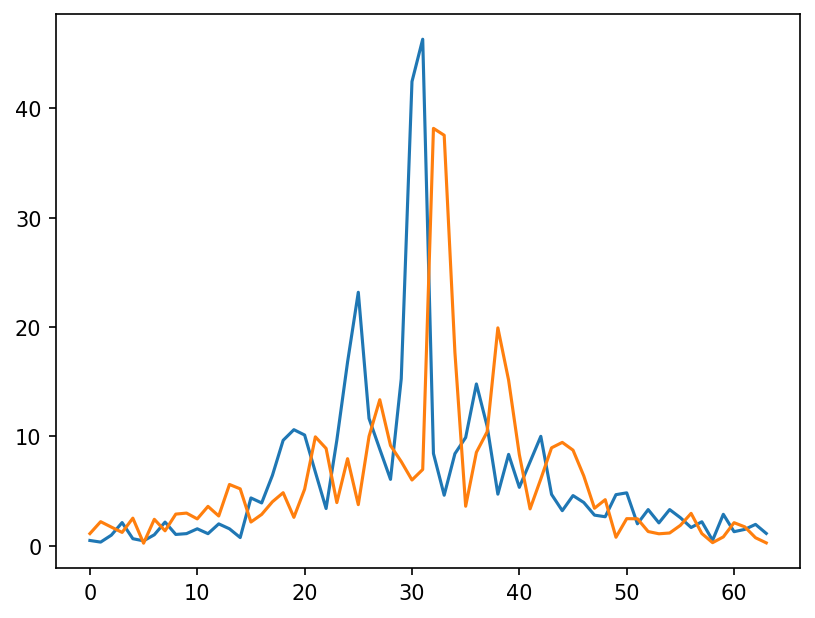

In [ ]:
# plt.plot(signal.numpy()[:512])
print(k_space.shape,signal.shape)
plt.plot(np.abs(k_space.numpy()[32]))

torch.Size([5504, 1])


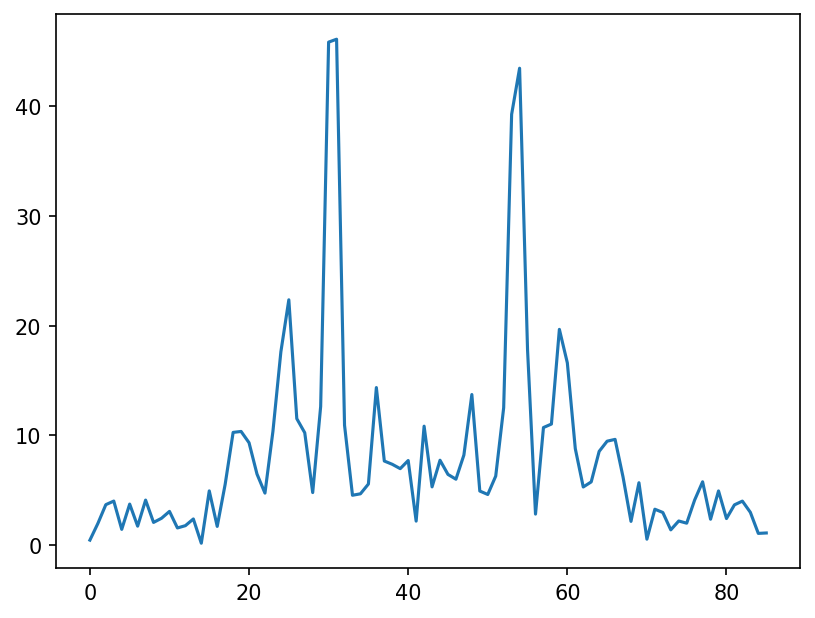

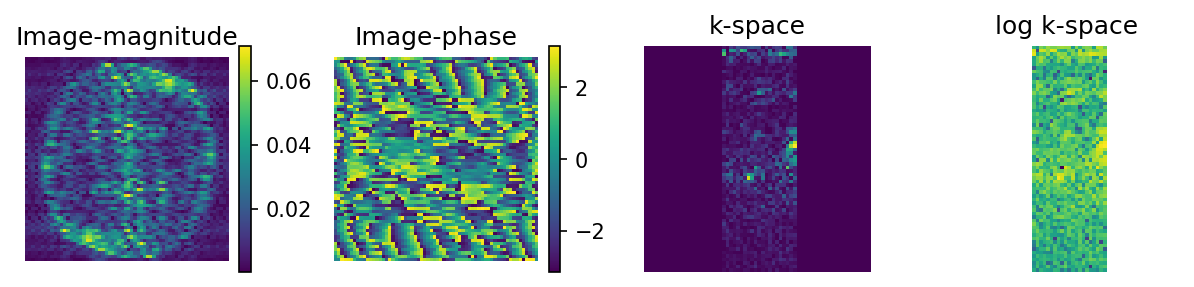

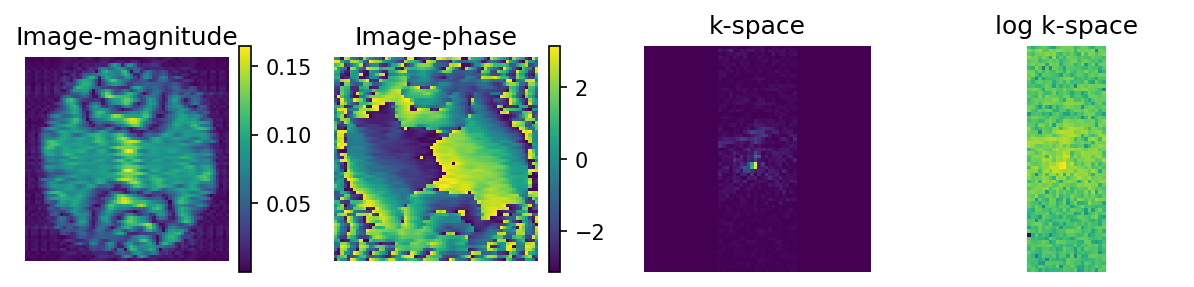

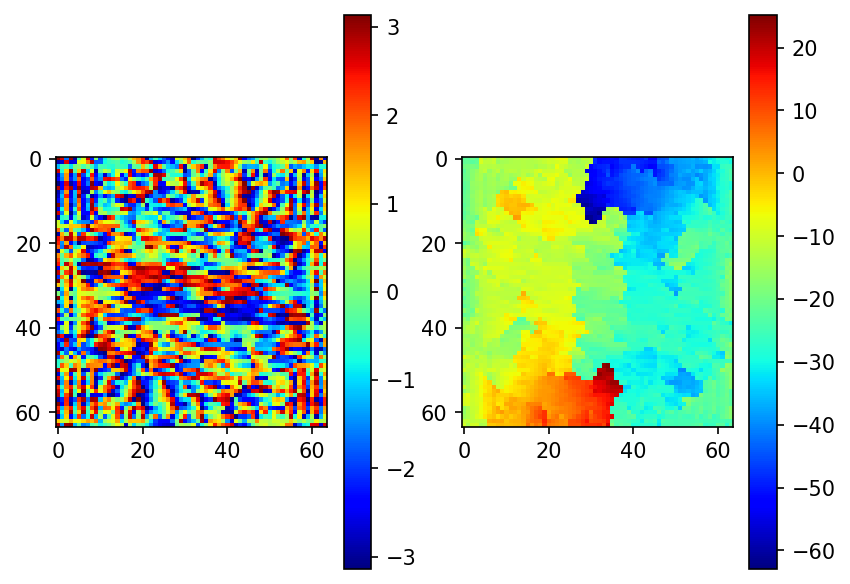

In [ ]:
from einops import rearrange
# seq_name = rf"solext3_gre_demo_2d_fov_shift_XXX"  # your sequence exp id in the matlab script
# seq_name = rf"solext2_gre_demo_2d_IR_XXX"  # your sequence exp id in the matlab script
# seq_name = rf"ex17_gre_demo_2d_Label_XXX"  # your sequence exp id in the matlab script
# seq_name = rf"bssfp"
# seq_name = rf"DESS"
seq_name = rf"QESS"
seq_path = rf"..\seq\{seq_name}.seq"

seq = pp.Sequence()
seq.read(seq_path)
signal, _ = mr0.util.simulate(seq, phantom)

# k_space_size = np.sqrt(signal.size()[0]).astype(int)
# DESS
# k_space_size = np.sqrt(signal.size()[0]/2).astype(int)
# QESS
# k_space_size = np.sqrt(signal.size()[0]/4).astype(int)
# print(rf"K space size: {k_space_size}")
print(signal.size()) # 42*4*64
# k_space = signal.reshape(k_space_size, k_space_size)
# spectrum = torch.fft.ifftshift(k_space)
# space = torch.fft.ifft2(spectrum)
# space = torch.fft.fftshift(space)
# DESS
# k_space = signal.reshape(64, 4, k_space_size)
kspace = signal.reshape(64,86)
# plt.imshow(np.abs(kspace.numpy()))
plt.plot(np.abs(kspace.numpy()[32,:]))

# kspace = rearrange(kspace, 'h c w -> h w c')
k_space = torch.zeros(64,64,4)
k_space[:,32-10:32+11,0] = kspace[:,:21]
k_space[:,32-11:32+11,1] = kspace[:,21:43]
k_space[:,32-11:32+11,2] = kspace[:,43:65]
k_space[:,32-11:32+10,3] = kspace[:,65:]
spectrum = torch.fft.ifftshift(k_space, dim=(0,1))
space = torch.fft.ifft2(spectrum, dim=(0,1))
space = torch.fft.fftshift(space, dim=(0,1))

# Plot the result
fraction = 0.05
cmap = None
# cmap = "gray"

fig, axes = plt.subplots(1, 4, figsize=(8, 6))

axes[0].set_title('Image-magnitude')
ax0 = axes[0].imshow(np.abs(space.numpy())[:,:,0], cmap=cmap)
# ax0 = axes[0].imshow(np.roll(np.abs(space.numpy()), space.shape[0]//2, axis=0), cmap=cmap)
fig.colorbar(ax0, ax=axes[0], fraction=fraction)

axes[1].set_title('Image-phase')
ax1 = axes[1].imshow(np.angle(space.numpy())[:,:,0], vmin=-np.pi, vmax=np.pi, cmap=cmap)
# ax1 = axes[1].imshow(np.roll(np.angle(space.numpy()), space.shape[0]//2, axis=0), vmin=-np.pi, vmax=np.pi, cmap=cmap)
fig.colorbar(ax1, ax=axes[1], fraction=fraction)

axes[2].set_title('k-space')
ax2 = axes[2].imshow(np.abs(k_space.numpy())[:,:,0], cmap=cmap)

axes[3].set_title('log k-space')
# ax3 = axes[3].imshow(np.log(np.abs(k_space.numpy())), cmap=cmap)
ax3 = axes[3].imshow(np.abs(k_space.numpy())[:,:,0], cmap=cmap, norm=LogNorm())

for ax in axes:
    ax.axis("off")

fig.tight_layout()

fig, axes = plt.subplots(1, 4, figsize=(8, 6))

axes[0].set_title('Image-magnitude')
ax0 = axes[0].imshow(np.abs(space.numpy())[:,:,1], cmap=cmap)
# ax0 = axes[0].imshow(np.roll(np.abs(space.numpy()), space.shape[0]//2, axis=0), cmap=cmap)
fig.colorbar(ax0, ax=axes[0], fraction=fraction)

axes[1].set_title('Image-phase')
ax1 = axes[1].imshow(np.angle(space.numpy())[:,:,1], vmin=-np.pi, vmax=np.pi, cmap=cmap)
# ax1 = axes[1].imshow(np.roll(np.angle(space.numpy()), space.shape[0]//2, axis=0), vmin=-np.pi, vmax=np.pi, cmap=cmap)
fig.colorbar(ax1, ax=axes[1], fraction=fraction)

axes[2].set_title('k-space')
ax2 = axes[2].imshow(np.abs(k_space.numpy())[:,:,1], cmap=cmap)

axes[3].set_title('log k-space')
# ax3 = axes[3].imshow(np.log(np.abs(k_space.numpy())), cmap=cmap)
ax3 = axes[3].imshow(np.abs(k_space.numpy())[:,:,1], cmap=cmap, norm=LogNorm())

for ax in axes:
    ax.axis("off")

fig.tight_layout()
plt.show()

# plt.imshow(np.abs(space.numpy().sum(axis=-1)))
from skimage.restoration import unwrap_phase
plt.subplot(121)
plt.imshow(np.angle(space[:,:,0]*space[:,:,1].conj()), cmap='jet')
plt.colorbar()
plt.subplot(122)
plt.imshow(unwrap_phase(np.angle(space[:,:,0]*space[:,:,1].conj())), cmap='jet')
plt.colorbar()